In [1]:
from ay_torch import *

In [2]:
FUNC_KIND=3
def Func(x):
  #NOTE: Switch the function to be learned.
  global FUNC_KIND
  if FUNC_KIND==0:  return x
  if FUNC_KIND==1:  return (x[:,0]**2).reshape((-1,1))
  if FUNC_KIND==2:  return (3.0-x[:,0]).reshape((-1,1))
  if FUNC_KIND==3:  return (x[:,0]+3.0*np.sin(x[:,0])).reshape((-1,1))
  if FUNC_KIND==4:  return np.where(x[:,0]**2<1.0, 3.0, 0.0).reshape((-1,1))

def GenerateSample(xmin, xmax, N_sample, f, noise=1.0e-10):
  data_x= np.random.uniform(xmin,xmax,size=(N_sample,1))
  data_y= f(data_x) + np.random.normal(scale=noise,size=(N_sample,1))
  return data_x,data_y

In [3]:
xmin,xmax= -5.0, 5.0
N_sample= 200
#NOTE: Adjust the sample size and noise level.
data_x,data_y= GenerateSample(xmin, xmax, N_sample, Func, noise=0.5)

#Convert data to torch variables.
data_x= torch.autograd.Variable(torch.from_numpy(data_x).float())
data_y= torch.autograd.Variable(torch.from_numpy(data_y).float())

#NOTE: Adjust the batch and epoch sizes.
N_batch= 50

#Make torch dataset and loader.
test_ratio= 0.2
idxes= np.random.RandomState(seed=42).permutation(data_x.shape[0])
N_train= round(data_x.shape[0]*(1.-test_ratio))
dset_train= torch.utils.data.TensorDataset(data_x[idxes[:N_train]], data_y[idxes[:N_train]])
dset_test= torch.utils.data.TensorDataset(data_x[idxes[N_train:]], data_y[idxes[N_train:]])
dl_train= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)
dl_test= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
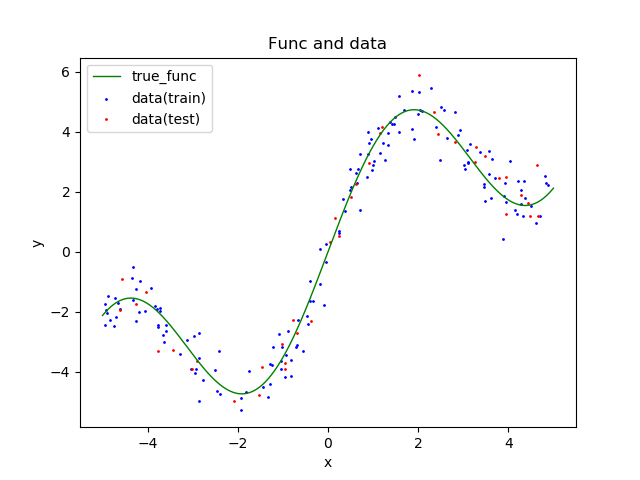

In [4]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], 1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], 1, color='red', label='data(test)')
ax_pred.legend()

In [5]:
class TRegNN1(torch.nn.Module):
  def __init__(self):
    super(TRegNN1,self).__init__()
    self.lin1= torch.nn.Linear(in_features=1, out_features=1, bias=True)
  def forward(self, x):
    x= self.lin1(x)
    return x

def DefRegNN2():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(200, 100),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(100, 1),
          )

def DefRegNN3():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN4():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN5(p=0.02):
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 1),
          )

In [6]:
def _f_test(x):
  return x*x*x
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + TFuncList((lambda x: x*x*x,))
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + [lambda x: x*x*x]
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + (lambda x: x*x*x)
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + TFuncList((_f_test,))
fl= TFuncList((lambda x: x+1, lambda x: x*x)) + _f_test
# fl+= [_f_test]
fl+= _f_test
# fl= TFuncList()
fl(x=10)
# type(fl)
# f1

[11, 100, 1000, 1000]

In [7]:
class _TFLTest(object):
  def __init__(self):
    self.x= 100
  def FL(self):
    return TFuncList((lambda y,self=self: self.x*y,lambda y,self=self: self.x+y+11))
flt= _TFLTest()
fl= flt.FL()
flt.x= 150
fl(10)

[1500, 171]

In [8]:
# Function forward test:
def f1(x, y=None, *args, **kwargs):
  print(x,y)
def f2(*args, **kwargs):
  f1(*args, **kwargs)
f2(100,y=100)

100 100


In [9]:
d1={1:1,2:2}
d2={2:3,3:3}
d3= d2
d4={3:4,5:5}
d3= MergeDict(d1, [d3,d4])
# d3= MergeDictSum(d1, [d3,d4])
print(d1,d2,d3)

{1: 1, 2: 3, 3: 4, 5: 5} {2: 3, 3: 3} {1: 1, 2: 3, 3: 4, 5: 5}


In [10]:
d1={1:[1],2:[2]}
d2={2:[3],3:[3]}
d3= d2
d4={3:[4],5:[5]}
# d3= MergeDict(d1, [d3,d4])
d3= MergeDictSum(d1, [d3,d4])
print(d1,d2,d3)

{1: [1], 2: [2, 3], 3: [3, 4], 5: [5]} {2: [3], 3: [3, 4]} {1: [1], 2: [2, 3], 3: [3, 4], 5: [5]}


In [15]:
#Setup a neural network.
#net= TRegNN1()
#net= DefRegNN2()
#net= DefRegNN3()
#net= DefRegNN4()
net= DefRegNN5()

device= torch.device('cpu')
# device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
#opt= torch.optim.SGD(net.parameters(), lr=0.004)
#opt= torch.optim.SGD(net.parameters(), lr=0.002, momentum=0.95)
#opt= torch.optim.Adadelta(net.parameters(), rho=0.9, eps=1e-8)
#opt= torch.optim.Adagrad(net.parameters())
#opt= torch.optim.RMSprop(net.parameters())
f_loss= torch.nn.MSELoss()
#f_loss= torch.nn.HuberLoss(reduction='mean', delta=0.1)

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return torch.autograd.Variable(x), torch.autograd.Variable(y)
logger= TLogger()
disp= TDisp()

In [16]:
next(net.parameters()).device==torch.device('cpu')

True

loss(train)	loss(test)	metric(test)	time
9.25723517	6.96714211	2.63199204	0.144260
7.42892838	5.15145504	2.26847392	0.111485
4.68195474	3.32295769	1.82118484	0.123625
3.16498935	3.35793805	1.82493481	0.108453
2.47350231	1.53783557	1.23765358	0.119856


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
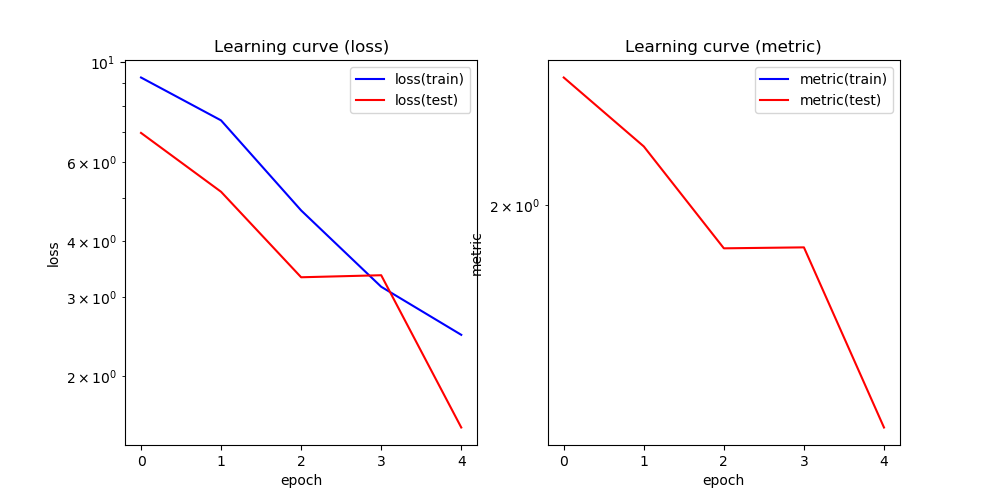

In [17]:
Fit(net, 5, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()

In [18]:
len(logger.loss_test)

5

In [20]:
[pg['lr'] for pg in opt.param_groups]
[pg.keys() for pg in opt.param_groups]
# opt
opt.state_dict()
# f_loss.state_dict()
# float('inf')

{'state': {},
 'param_groups': [{'lr': 0.01,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
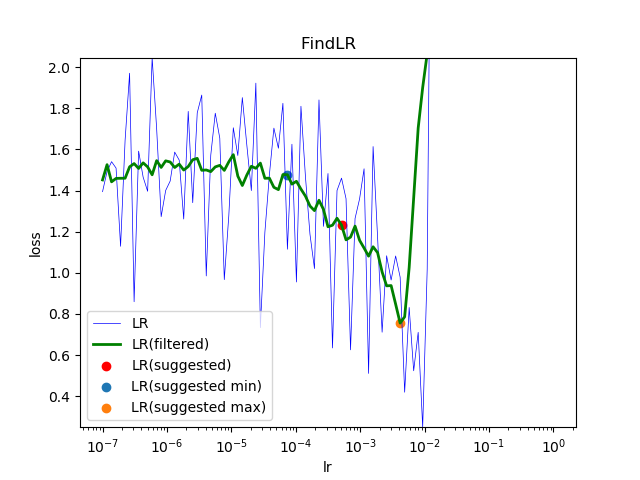

lr= 0.000512861383991365


In [19]:
lr,_= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}')

loss(train)	loss(test)	metric(test)	time
1.44096732	1.38130122	1.17199406	0.126491
1.30470449	1.38179719	1.16996506	0.084265
1.68647549	1.17135233	1.06220491	0.125321
1.39077303	1.32287034	1.14694571	0.106025
1.19864523	1.18915579	1.08958414	0.098693


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
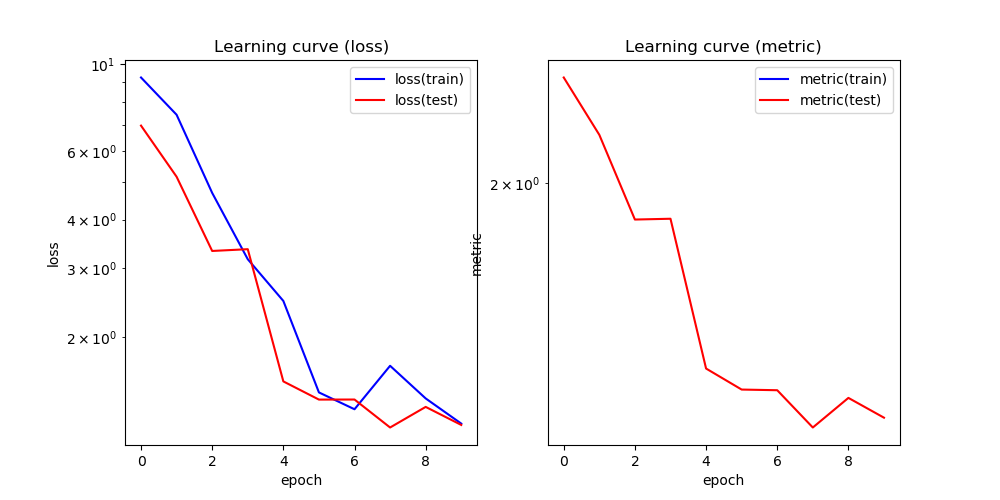

In [20]:
Fit(net, n_epoch=5, lr=lr, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
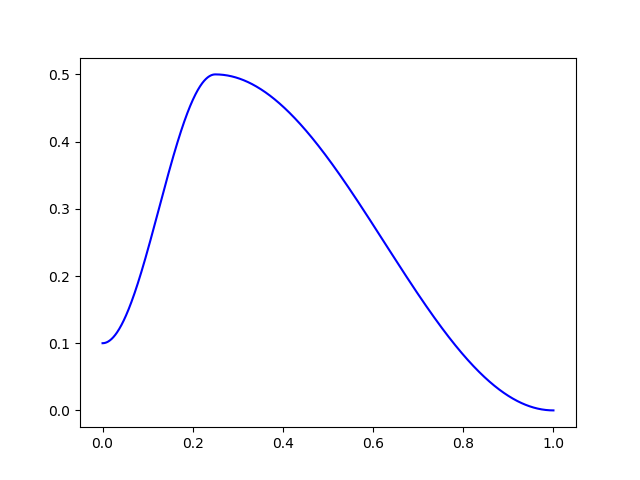

In [21]:
# via_pos= np.array([0,0.1,0.23,0.5,0.8,1.0])
# pos= np.array([0.0, 0.12, 1.2]).reshape(-1,1)
# max(0,min(len(via_pos)-2, sum(pos>=via_pos)-1))
# np.sum(pos>=via_pos,axis=1)
# cosa= lambda start,end,pos: start + (1 + np.cos(np.pi*(1-pos))) * (end-start) / 2
# sch= TScheduler('exp', 1, 0.1)
sch= TCmbScheduler(((0,0.1),(0.25,0.5),(1.0,1e-5)), ('cos','cos'))
fig, ax_loss= plt.subplots(1,1)
X= np.linspace(0,1,1000)
ax_loss.plot(X, [sch(x) for x in X], color='blue', label='LR')

In [22]:
TFuncList([TScheduler('exp', s, e) for s,e in zip([0.01,0.1],[1,10])])(0.2)

[0.0251188643150958, 0.251188643150958]

In [23]:
(lambda p: (TCmbScheduler(((0,0.1),(0.25,0.5),(1.0,1e-5)), ('cos','cos'))(p),
            TCmbScheduler(((0,np.array([0.1,0.01])),(0.25,np.array([0.5,0.05])),(1.0,np.array([1e-5,1e-6]))), ('cos','cos'))(p)))(0.5)

(0.37500250000000007, array([0.3750025 , 0.03750025]))

In [24]:
# learn.lr_find()
# learn.fit_one_cycle(10, 0.006); moms=(0.95,0.85,0.95)
torch.optim.SGD(torch.nn.Linear(1,1).parameters(), lr=0.002, momentum=0.95).param_groups
# torch.optim.Adam(torch.nn.Linear(1,1).parameters(), lr=0.002).param_groups

[{'params': [Parameter containing:
   tensor([[0.5876]], requires_grad=True),
   Parameter containing:
   tensor([0.7755], requires_grad=True)],
  'lr': 0.002,
  'momentum': 0.95,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False}]

loss(train)	loss(test)	metric(test)	time
1.08513752	1.21811073	1.10056488	0.127998
17.39845744	8.39595711	2.87957776	0.115481
16.69851863	12.03015780	3.46076113	0.097419
11.67202568	9.56496596	3.09249151	0.111528
8.87092197	5.63546145	2.36097175	0.119648
5.30467343	3.53758484	1.87379810	0.070852
2.60919434	2.61930931	1.61399975	0.104227
2.58919966	2.03453049	1.40917853	0.104046
1.82400042	1.39831583	1.17436801	0.117583
1.43382874	1.32408708	1.14842272	0.112081


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
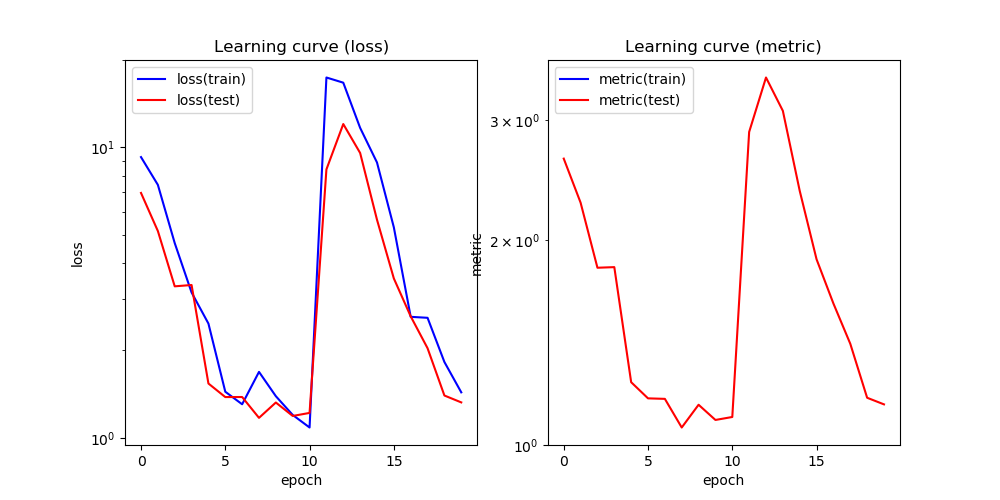

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
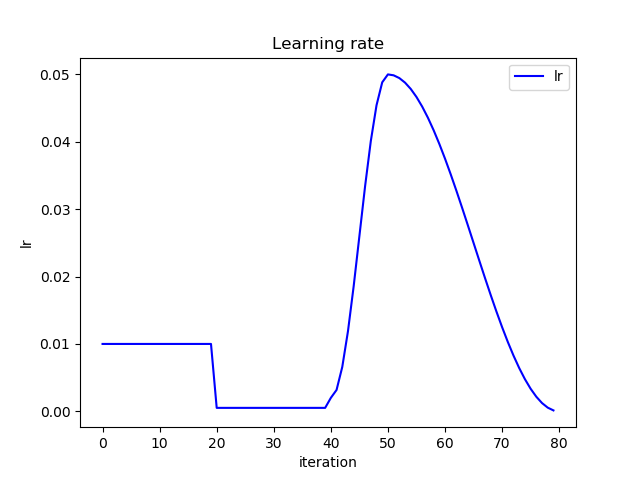

In [25]:
FitOneCycle(net, n_epoch=10, lr_max=0.05, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
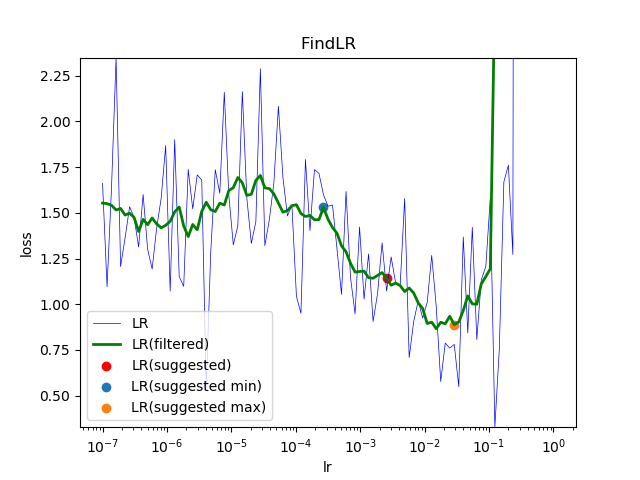

lr= 0.0025703957827688637, lr_min=0.0002691534803926915, lr_max=0.02884031503126607


In [26]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

loss(train)	loss(test)	metric(test)	time
1.40238723	1.39650111	1.16534925	0.129900
1.43047917	1.19487357	1.08806711	0.105211
1.23339388	0.86800745	0.92648113	0.107711
1.03327328	1.22946560	1.10510764	0.120423
0.99369045	0.75508662	0.86565162	0.133424
0.88462631	1.00679375	1.00224380	0.110215
1.02033237	0.62926250	0.78864664	0.134821
0.70314671	0.58901945	0.75828877	0.104006
0.69455102	0.35415886	0.59258291	0.116580
0.57568499	0.36726069	0.60252421	0.112147
0.50317612	0.40269835	0.63166167	0.129113
0.44252976	0.41553160	0.64231551	0.122264
0.72153785	0.35122114	0.59131494	0.132659
0.53906488	0.35592756	0.59383258	0.131239
0.45816604	0.37176155	0.60887520	0.109257
0.43389031	0.32222261	0.56359988	0.125574
0.50510976	0.34375104	0.58411801	0.121618
0.43053557	0.34818909	0.58695195	0.110363
0.46537651	0.31074878	0.55546591	0.117432
0.55720194	0.31841549	0.56180227	0.123707


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
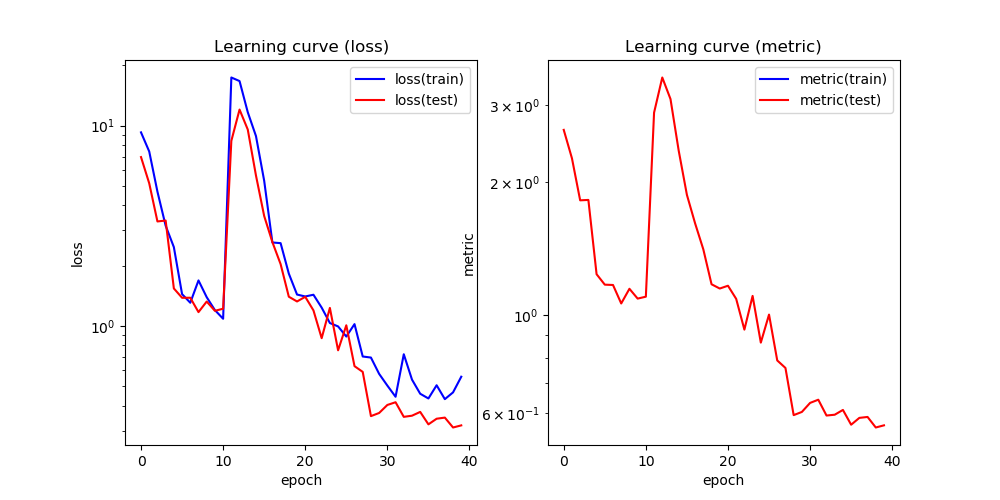

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
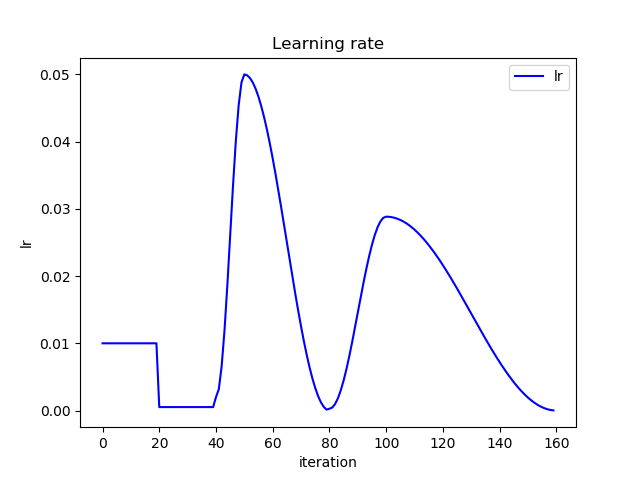

In [27]:
FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()